<a href="https://colab.research.google.com/github/matsunagalab/lecture_ML/blob/main/machine_learning_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第14回 ベイズ推論その1 基本的事項

## 赤玉白玉問題: 二袋の場合でデータからどちらの袋を選んだかを推論

2つの袋 a と b に赤玉と白玉が入っている。
袋aには、赤玉が2個、白玉が1個入っている。
袋bには、赤玉が1個、白玉が3個入っている。
はじめに、袋 a か b を1/2の確率で選び、選んだ袋から玉をひとつ取り出す試行を8回行った。
その結果、順番に以下の玉が観測された。赤玉をr、白玉をwとする。
{r, r, w, w, r, r, w, r}

このとき、袋aを選んでいた確率(事後確率)を求めよ。


In [123]:
# 袋aを選ぶ確率
prior = 1.0 / 2.0

# 袋aを選んで8回のうち赤玉が5回出る(そのうちの一通りのパターンが出る)確率
likelihood = (2.0 / 3.0)**5 * (1.0 / 3.0)**3

# 袋によらず8回のうち赤玉が5回出る(そのうちの一通りのパターンが出る)確率
evidence = 0.5 * (2.0 / 3.0)**5 * (1.0 / 3.0)**3 + 0.5 * (1.0 / 4.0)**5 * (3.0 / 4.0)**3

posterior = likelihood * prior / evidence

print(posterior)

0.9221091861712114


## 赤玉白玉問題: 一袋の場合でデータから赤玉の割合を推論

今度は一袋だけを考える。袋には、赤玉が1個、白玉が2個入っているがそれを知らないとする。
何回か玉を取り出して戻す操作を繰り返したときに、赤玉が入っている割合θを事後分布として求める。

この計算には、確率的プログラミングのフレームワークである PyMC www.pymc.io を用いる。
これは、確率分布を求めるためのフレームワークで、ベイズ推論を行うために便利である。

特徴として、各変数を定義するときに、その変数が従うべき分布を与えて定義する。すなわち、変数を確率変数として定義することができる。その上で、定義した確率変数から事後分布などを計算することができる。詳しくは PyMCのドキュメント www.pymc.io を参照のこと。

Running on PyMC v5.1.2


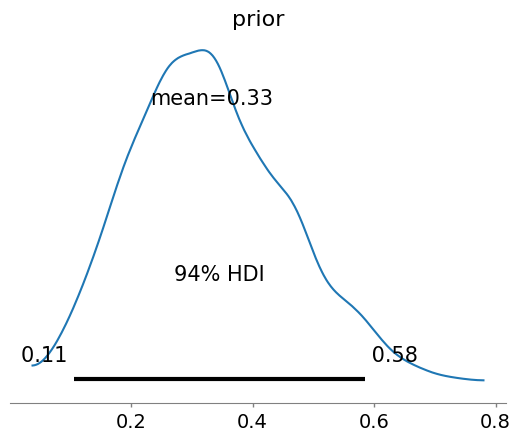

In [127]:
import pymc as pm
import arviz as az
print(f"Running on PyMC v{pm.__version__}")

# 玉を取り出して戻した回数
n_trial = 10
# 赤玉が出た回数
n_red = 3

# モデルの定義と事後確率θのサンプリング
with pm.Model() as red_white_model:
    # 赤玉を選ぶ事前確率としてベータ分布を仮定
    prior = pm.Beta("prior", alpha=1, beta=1)

    # 尤度関数は二項分布
    obs = pm.Binomial("obs", p=prior, n=n_trial,
        observed=n_red,
    )

    # 赤玉の割合θの事後分布をサンプリング
    idata = pm.sample()

ax = az.plot_posterior(idata, show=True);

In [128]:
import random

balls = [1, 0, 0]  # 赤玉1、白玉0
n_trials = [0, 3, 10, 100]
beta_params = [(0.5, 0.5), (1.0, 1.0), (5, 2)]
idatum = []

for beta_param in beta_params:
    for n_trial in n_trials:
        # モデルの定義と事後確率θのサンプリング
        with pm.Model() as red_white_model:
            # 赤玉を選ぶ事前確率としてベータ分布を仮定
            prior = pm.Beta("prior", alpha=beta_param[0], beta=beta_param[1])

            # 赤玉が出た回数を乱数で計算して観測値とする
            n_red = sum(random.choice(balls) for _ in range(n_trial))

            # 尤度関数は二項分布
            obs = pm.Binomial("obs", p=prior, n=n_trial,
                observed=n_red,
            )

            # 赤玉の割合θの事後分布をサンプリング
            idata = pm.sample()
            idatum.append(idata)

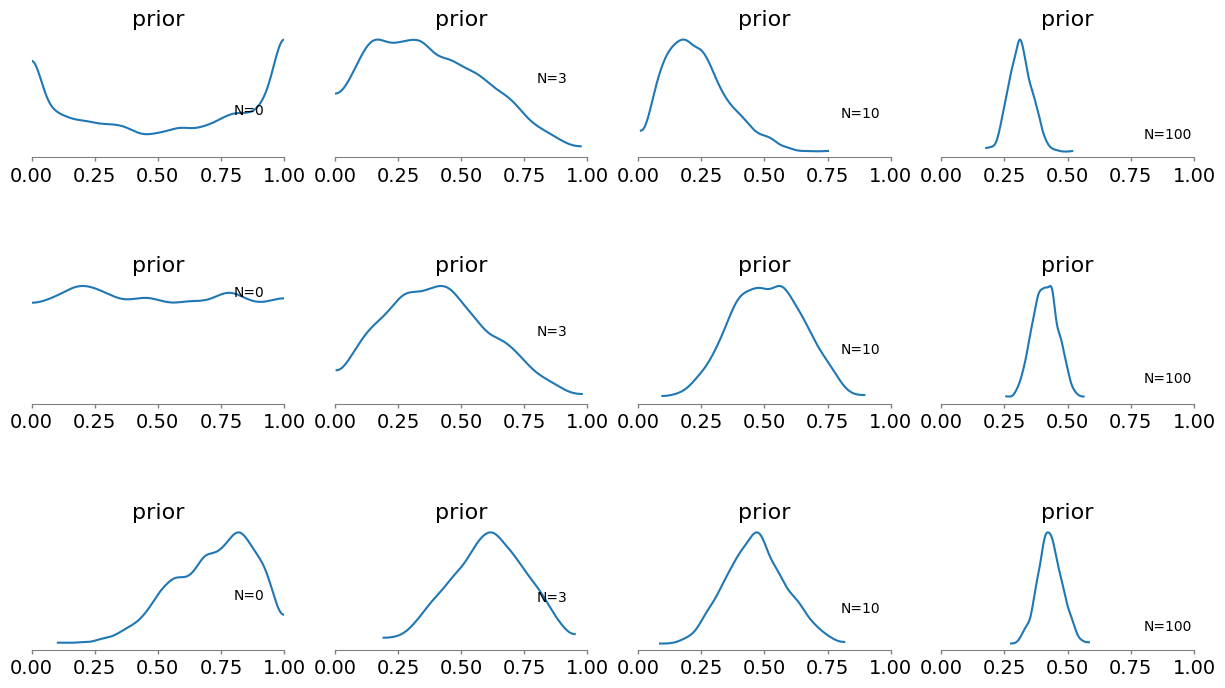

In [129]:
import arviz as az
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 4, figsize=(15, 8))
plt.subplots_adjust(hspace=1)

count = 0
for i in range(12):
    ii = i//4
    jj = i%4
    ax = axs[ii, jj]
    ax.set_xlim(xmin=0, xmax=1)
    ax.set_frame_on(True)
    az.plot_posterior(
        idatum[count],
        group="posterior",
        hdi_prob="hide",
        point_estimate=None,
#        textsize=0,
        ax=ax)
    #ax.tick_params(axis='y', which='both', bottom=True, top=False, labelbottom=True)
    ax.text(0.8, 1.0, f"N={n_trials[jj]}")
    count += 1

plt.show()